# **Problem Statement**

## **Business Context**

Workplace safety in hazardous environments like construction sites and industrial plants is crucial to prevent accidents and injuries. One of the most important safety measures is ensuring workers wear safety helmets, which protect against head injuries from falling objects and machinery. Non-compliance with helmet regulations increases the risk of serious injuries or fatalities, making effective monitoring essential, especially in large-scale operations where manual oversight is prone to errors and inefficiency.

To overcome these challenges, SafeGuard Corp plans to develop an automated image analysis system capable of detecting whether workers are wearing safety helmets. This system will improve safety enforcement, ensuring compliance and reducing the risk of head injuries. By automating helmet monitoring, SafeGuard aims to enhance efficiency, scalability, and accuracy, ultimately fostering a safer work environment while minimizing human error in safety oversight.

## **Objective**

As a data scientist at SafeGuard Corp, you are tasked with developing an image classification model that classifies images into one of two categories:
- **With Helmet:** Workers wearing safety helmets.
- **Without Helmet:** Workers not wearing safety helmets.

## **Data Description**

The dataset consists of **631 images**, equally divided into two categories:

- **With Helmet:** 311 images showing workers wearing helmets.
- **Without Helmet:** 320 images showing workers not wearing helmets.

**Dataset Characteristics:**
- **Variations in Conditions:** Images include diverse environments such as construction sites, factories, and industrial settings, with variations in lighting, angles, and worker postures to simulate real-world conditions.
- **Worker Activities:** Workers are depicted in different actions such as standing, using tools, or moving, ensuring robust model learning for various scenarios.

# **Installing and Importing the Necessary Libraries**

In [9]:
%pip install numpy pandas matplotlib seaborn scikit-learn opencv-python tensorflow keras pillow  -q

Note: you may need to restart the kernel to use updated packages.


In [10]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available: 0
2.20.0


**Note:**

- After running the above cell, kindly restart the notebook kernel (for Jupyter Notebook) or runtime (for Google Colab) and run all cells sequentially from the next cell.

- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in this notebook.

In [11]:
import os
import random
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2


# Tensorflow modules
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16                                               # Importing confusion_matrix to plot the confusion matrix

# Display images using OpenCV
# from google.colab.patches import cv2_imshow

#Imports functions for evaluating the performance of machine learning models
from sklearn.metrics import confusion_matrix, f1_score,accuracy_score, recall_score, precision_score, classification_report
from sklearn.metrics import mean_squared_error as mse                                                 # Importing cv2_imshow from google.patches to display images

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [12]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
tf.keras.utils.set_random_seed(812)

# **Data Overview**


##Loading the data

In [41]:
images = np.load('images_proj.npy')
labels = pd.read_csv('labels_proj.csv')

In [42]:
print(f'Images shape: {images.shape}')
print(f'Labels shape: {labels.shape}')

print(labels.value_counts())

Images shape: (631, 200, 200, 3)
Labels shape: (631, 1)
Label
0        320
1        311
Name: count, dtype: int64


In [60]:
print("minimum value of the image array is ",np.min(images[0]))
print("maximum value of the image array is",np.max(images[0]))

minimum value of the image array is  0
maximum value of the image array is 255


#### Observations
* The no of images given to train and test split are less --> 631
* The image counts are balanced 320, 311

# **Exploratory Data Analysis**

###Plot random images from each of the classes and print their corresponding labels.

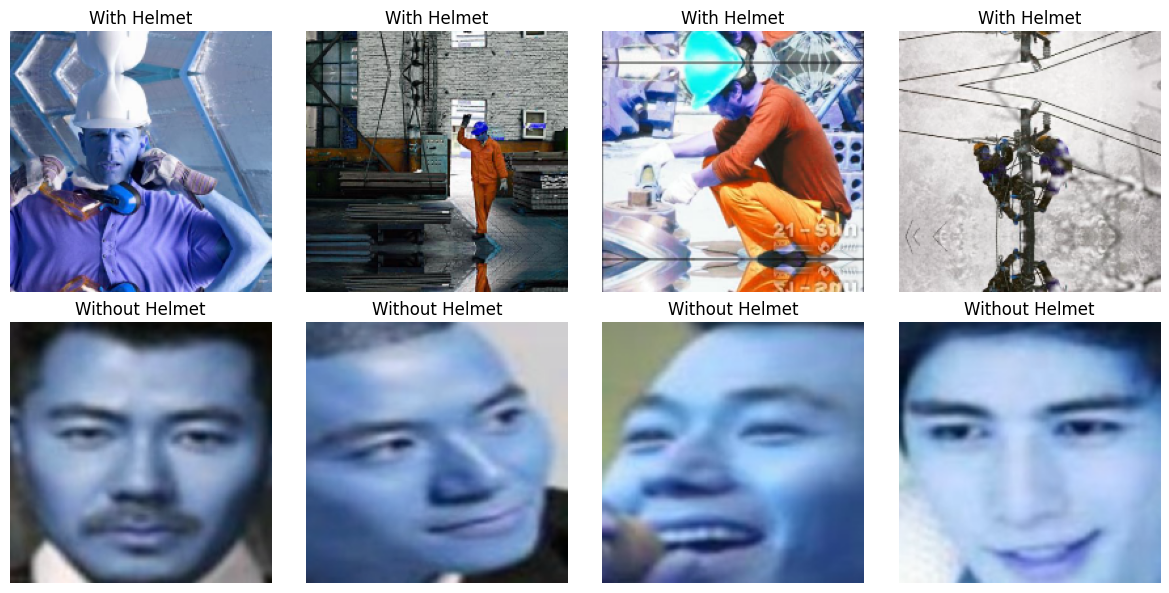

In [48]:
def plot_sample_images(images, labels, num_samples=4):
    with_helmet_indices = labels[labels['Label'] == 1].index.tolist()
    without_helmet_indices = labels[labels['Label'] == 0].index.tolist()
    plt.figure(figsize=(12, 6))
    for i in range(num_samples):
        idx = random.choice(with_helmet_indices)
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(images[idx])
        plt.title('With Helmet')
        plt.axis('off')
    
    # Plot random images without helmet
    for i in range(num_samples):
        idx = random.choice(without_helmet_indices)
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(images[idx])
        plt.title('Without Helmet')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display random samples of images with and without helmets
plot_sample_images(images,labels)

##### Observation 
* the data sample looks to be very simple, as without helmet images are mostly closeups to face

did run this sample multiple times and saw that almost all images without helmet are closeups. 

## Checking for class imbalance


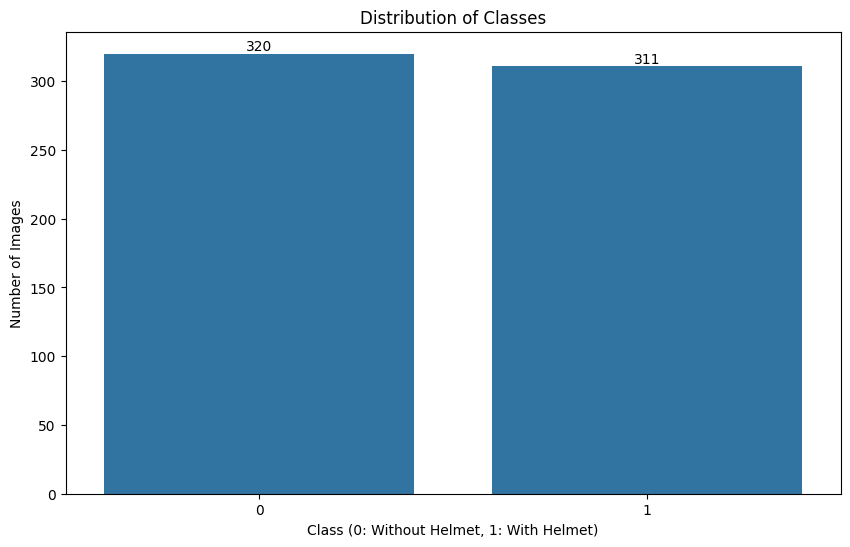


Percentage Distribution:
Class 0: 50.71%
Class 1: 49.29%


In [49]:
# Count the number of images in each class
class_distribution = labels['Label'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title('Distribution of Classes')
plt.xlabel('Class (0: Without Helmet, 1: With Helmet)')
plt.ylabel('Number of Images')

# Add value labels on top of each bar
for i, v in enumerate(class_distribution.values):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()

# Calculate the percentage distribution
percentage_distribution = (class_distribution / len(labels) * 100).round(2)
print("\nPercentage Distribution:")
for class_label, percentage in percentage_distribution.items():
    print(f"Class {class_label}: {percentage}%")

##### Observations
* As observed earlier, we are seeing that the distribution is fairly even

# **Data Preprocessing**

## Converting images to grayscale

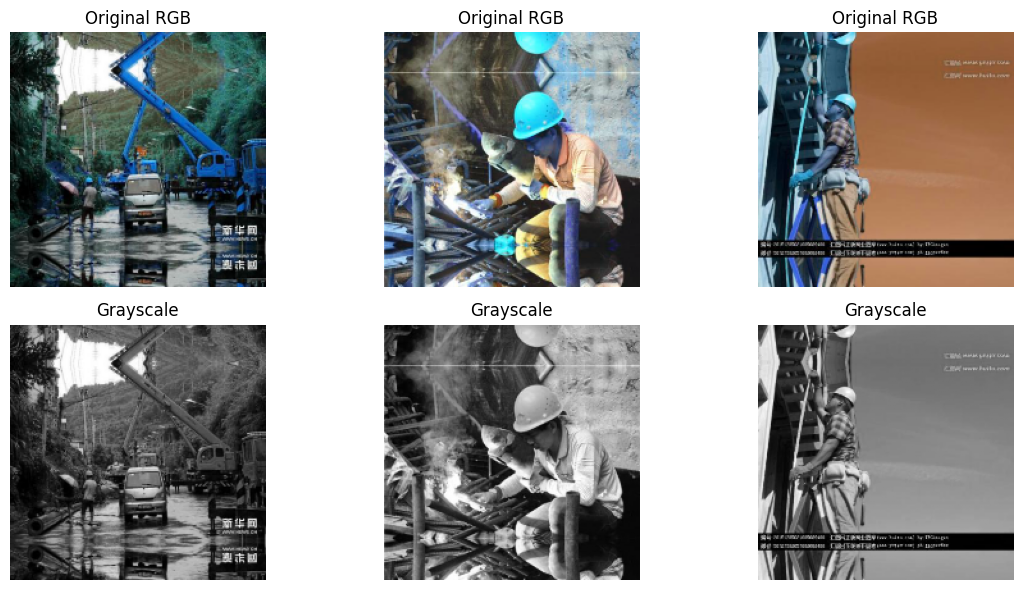

Original image shape: (200, 200, 3)
Grayscale image shape: (200, 200, 1)


In [50]:
# Function to convert RGB images to grayscale
def convert_to_grayscale(images):
    gray_images = []
    for img in images:
        # Convert RGB to grayscale using cv2
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Add channel dimension for CNN input (H, W, 1)
        gray_img = gray_img[..., np.newaxis]
        gray_images.append(gray_img)
    return np.array(gray_images)

# Convert images to grayscale
gray_images = convert_to_grayscale(images)

# Display sample images before and after conversion
plt.figure(figsize=(12, 6))
for i in range(3):
    # Original RGB image
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i])
    plt.title('Original RGB')
    plt.axis('off')
    
    # Grayscale image
    plt.subplot(2, 3, i + 4)
    plt.imshow(gray_images[i].squeeze(), cmap='gray')
    plt.title('Grayscale')
    plt.axis('off')

plt.tight_layout()
plt.show()

print("Original image shape:", images[0].shape)
print("Grayscale image shape:", gray_images[0].shape)

In [51]:
# Apply Gaussian blur to the grayscale images
def apply_gaussian_blur(images, kernel_size=(5,5)):
    blurred_images = []
    for img in images:
        # Apply Gaussian blur
        blurred = cv2.GaussianBlur(img, kernel_size, 0)
        blurred_images.append(blurred)
    return np.array(blurred_images)

# Apply blur to grayscale images
blurred_images = apply_gaussian_blur(gray_images)


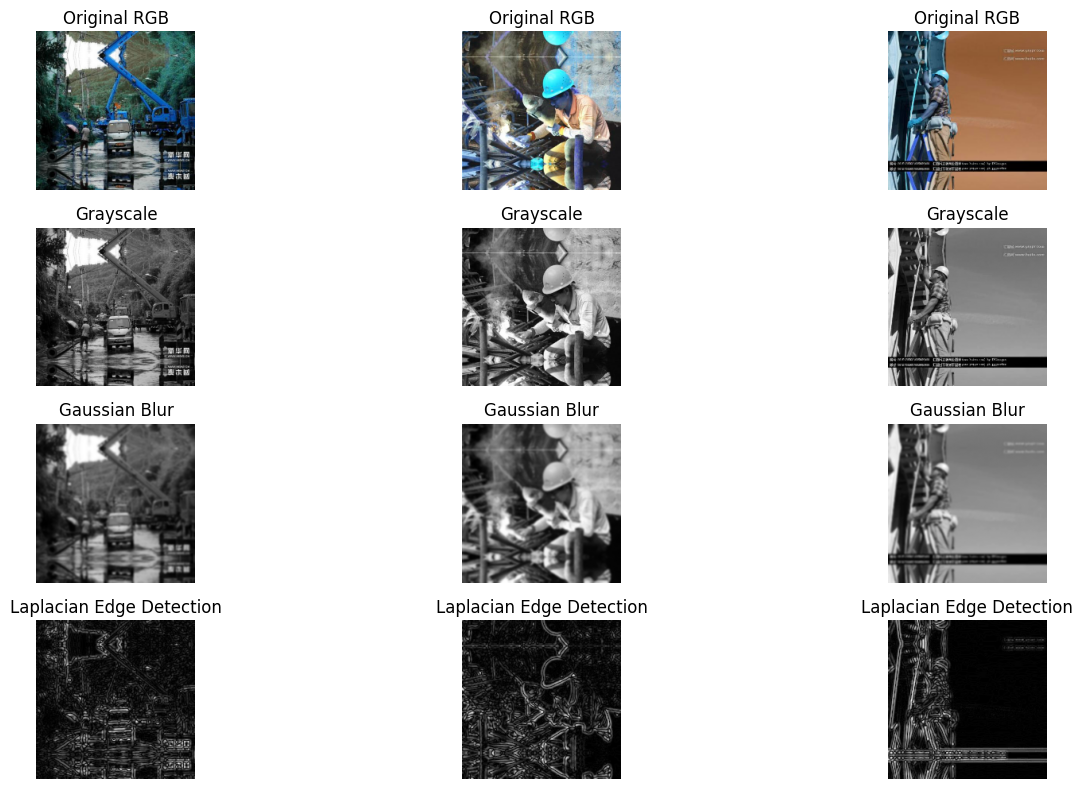

Original image shape: (200, 200, 3)
Grayscale image shape: (200, 200, 1)
Blurred image shape: (200, 200)
Laplacian image shape: (200, 200)


In [ ]:
# Apply Laplacian edge detection to the grayscale images
def apply_laplacian(images, ksize=3):
    laplacian_images = []
    for img in images:
        # Apply Gaussian blur first to reduce noise
        blurred = cv2.GaussianBlur(img, (5,5), 0)
        # Apply Laplacian
        laplacian = cv2.Laplacian(blurred, cv2.CV_64F, ksize=ksize)
        # Convert back to uint8 and normalize to 0-255 range
        laplacian = np.uint8(np.absolute(laplacian))
        laplacian_images.append(laplacian)
    return np.array(laplacian_images)

# Apply Laplacian edge detection on grayscale images
laplacian_images = apply_laplacian(gray_images)

# Display sample images to compare all preprocessing steps
plt.figure(figsize=(15, 8))
for i in range(3):
    # Original RGB image
    plt.subplot(4, 3, i + 1)
    plt.imshow(images[i])
    plt.title('Original RGB')
    plt.axis('off')
    
    # Grayscale image
    plt.subplot(4, 3, i + 4)
    plt.imshow(gray_images[i].squeeze(), cmap='gray')
    plt.title('Grayscale')
    plt.axis('off')
    
    # Blurred image
    plt.subplot(4, 3, i + 7)
    plt.imshow(blurred_images[i].squeeze(), cmap='gray')
    plt.title('Gaussian Blur')
    plt.axis('off')
    
    # Laplacian image
    plt.subplot(4, 3, i + 10)
    plt.imshow(laplacian_images[i].squeeze(), cmap='gray')
    plt.title('Laplacian Edge Detection')
    plt.axis('off')

plt.tight_layout()
plt.show()

print("Original image shape:", images[0].shape)
print("Grayscale image shape:", gray_images[0].shape)
print("Blurred image shape:", blurred_images[0].shape)
print("Laplacian image shape:", laplacian_images[0].shape)

### Splitting the dataset



In [66]:
# images, gray_images, blurred_images, laplacian_images
# splitting the data into training and testing sets , since there are only 631 samples, we are using 60% for training, 20% for validation and 20% for testing
# splitting rgb images
x_train_rgb, x_temp_rgb, y_train_rgb, y_temp_rgb = train_test_split(images, labels['Label'], test_size=0.4, random_state=42, stratify=labels['Label'])
x_val_rgb, x_test_rgb, y_val_rgb, y_test_rgb = train_test_split(x_temp_rgb, y_temp_rgb, test_size=0.5, random_state=42, stratify=y_temp_rgb)

In [67]:
# splitting grayscale images
x_train_gray, x_temp_gray, y_train_gray, y_temp_gray = train_test_split(gray_images, labels['Label'], test_size=0.4, random_state=42, stratify=labels['Label'])
x_val_gray, x_test_gray, y_val_gray, y_test_gray = train_test_split(x_temp_gray, y_temp_gray, test_size=0.5, random_state=42, stratify=y_temp_gray)

In [68]:
# splitting blurred images
x_train_blur, x_temp_blur, y_train_blur, y_temp_blur = train_test_split(blurred_images, labels['Label'], test_size=0.4, random_state=42, stratify=labels['Label'])
x_val_blur, x_test_blur, y_val_blur, y_test_blur = train_test_split(x_temp_blur, y_temp_blur, test_size=0.5, random_state=42, stratify=y_temp_blur)

In [69]:
# splitting laplacian images
x_train_lap, x_temp_lap, y_train_lap, y_temp_lap = train_test_split(laplacian_images, labels['Label'], test_size=0.4, random_state=42, stratify=labels['Label'])
x_val_lap, x_test_lap, y_val_lap, y_test_lap = train_test_split(x_temp_lap, y_temp_lap, test_size=0.5, random_state=42, stratify=y_temp_lap)

### Data Normalization

In [70]:
# label binarizer is not needed as the labels are already in binary format (0 and 1)
# as we observed earlier in data exploration the values are between 0 and 255, lets normalize them
# normalizing rgb images
x_train_normalized_rgb = x_train_rgb.astype('float32') / 255.0
x_val_normalized_rgb = x_val_rgb.astype('float32') / 255.0
x_test_normalized_rgb = x_test_rgb.astype('float32') / 255.0

In [71]:
# normalizing grayscale images
x_train_normalized_gray = x_train_gray.astype('float32') / 255.0
x_val_normalized_gray = x_val_gray.astype('float32') / 255.0
x_test_normalized_gray = x_test_gray.astype('float32') / 255.0

In [72]:
# normalizing blurred images
x_train_normalized_blur = x_train_blur.astype('float32') / 255.0
x_val_normalized_blur = x_val_blur.astype('float32') / 255.0
x_test_normalized_blur = x_test_blur.astype('float32') / 255.0

In [73]:
# normalizing laplacian images
x_train_normalized_lap = x_train_lap.astype('float32') / 255.0
x_val_normalized_lap = x_val_lap.astype('float32') / 255.0
x_test_normalized_lap = x_test_lap.astype('float32') / 255.0

* Normalized the data sets to train the models

* we will build all our models now for RGB and later work on others

# **Model Building**

##Model Evaluation Criterion

## Utility Functions

In [74]:
# defining a function to compute different metrics to check performance of a classification model built using statsmodels
def model_performance_classification(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # checking which probabilities are greater than threshold
    pred = model.predict(predictors).reshape(-1)>0.5

    target = target.to_numpy().reshape(-1)


    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred, average='weighted')  # to compute Recall
    precision = precision_score(target, pred, average='weighted')  # to compute Precision
    f1 = f1_score(target, pred, average='weighted')  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame({"Accuracy": acc, "Recall": recall, "Precision": precision, "F1 Score": f1,},index=[0],)

    return df_perf

In [75]:
def plot_confusion_matrix(model,predictors,target,ml=False):
    """
    Function to plot the confusion matrix

    model: classifier
    predictors: independent variables
    target: dependent variable
    ml: To specify if the model used is an sklearn ML model or not (True means ML model)
    """

    # checking which probabilities are greater than threshold
    pred = model.predict(predictors).reshape(-1)>0.5

    target = target.to_numpy().reshape(-1)

    # Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
    confusion_matrix = tf.math.confusion_matrix(target,pred)
    f, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        confusion_matrix,
        annot=True,
        linewidths=.4,
        fmt="d",
        square=True,
        ax=ax
    )
    plt.show()

##Model 1: Simple Convolutional Neural Network (CNN)

In [76]:
# Basic CNN model for helmet detection (using RGB images)
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=x_train_rgb.shape[1:]),#200,200,3
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 147456)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     9,437,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,456,705 (36.07 MB)

 Trainable params: 9,456,705 (36.07 MB)

 Non-trainable params: 0 (0.00 B)

In [77]:
# Fit the basic CNN model using normalized RGB images
history_basic_cnn = cnn_model.fit(
    x_train_normalized_rgb, y_train_rgb,
    epochs=20,
    batch_size=32,
    validation_data=(x_val_normalized_rgb, y_val_rgb),
    verbose=2,
    shuffle=True
)

Epoch 1/20
12/12 - 3s - 278ms/step - accuracy: 0.6534 - loss: 1.3288 - val_accuracy: 0.9206 - val_loss: 0.2089
Epoch 2/20
12/12 - 3s - 278ms/step - accuracy: 0.6534 - loss: 1.3288 - val_accuracy: 0.9206 - val_loss: 0.2089
Epoch 2/20
12/12 - 2s - 197ms/step - accuracy: 0.9656 - loss: 0.1129 - val_accuracy: 0.9524 - val_loss: 0.1005
Epoch 3/20
12/12 - 2s - 197ms/step - accuracy: 0.9656 - loss: 0.1129 - val_accuracy: 0.9524 - val_loss: 0.1005
Epoch 3/20
12/12 - 2s - 192ms/step - accuracy: 0.9709 - loss: 0.0821 - val_accuracy: 0.9683 - val_loss: 0.0765
Epoch 4/20
12/12 - 2s - 192ms/step - accuracy: 0.9709 - loss: 0.0821 - val_accuracy: 0.9683 - val_loss: 0.0765
Epoch 4/20
12/12 - 2s - 192ms/step - accuracy: 0.9894 - loss: 0.0298 - val_accuracy: 0.9762 - val_loss: 0.0407
Epoch 5/20
12/12 - 2s - 192ms/step - accuracy: 0.9894 - loss: 0.0298 - val_accuracy: 0.9762 - val_loss: 0.0407
Epoch 5/20
12/12 - 2s - 200ms/step - accuracy: 0.9974 - loss: 0.0134 - val_accuracy: 0.9762 - val_loss: 0.0539
E

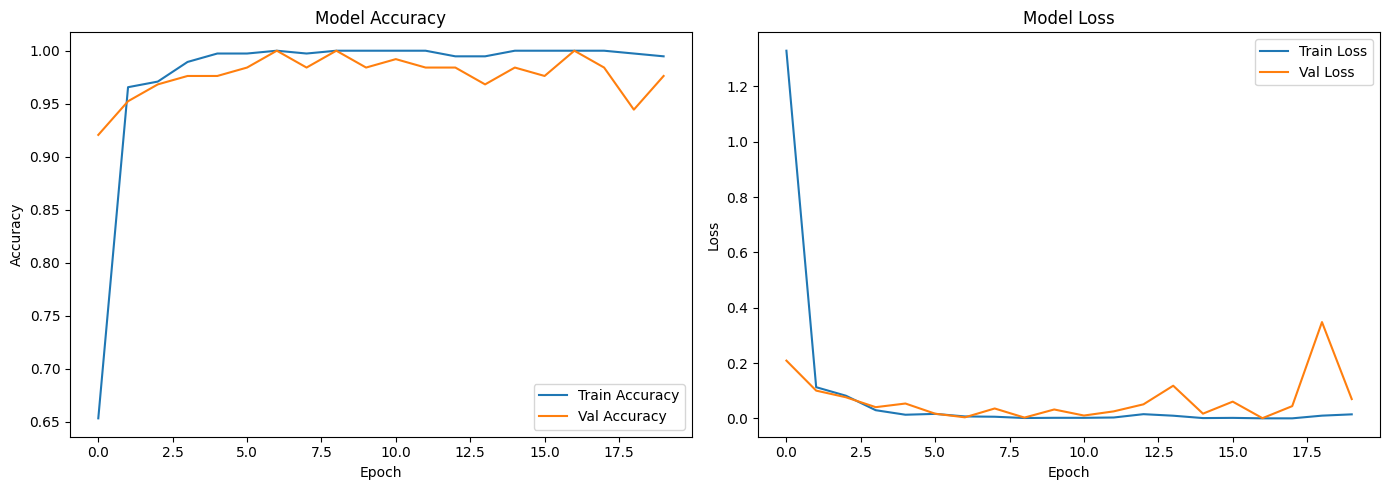

In [78]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_basic_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_basic_cnn.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_basic_cnn.history['loss'], label='Train Loss')
plt.plot(history_basic_cnn.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [84]:

performance_test_basic_cnn = model_performance_classification(cnn_model, x_test_normalized_rgb, y_test_rgb)
print("Performance of Basic CNN Model on Test set of RGB Images:")
print(performance_test_basic_cnn)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Performance of Basic CNN Model on Test set of RGB Images:
   Accuracy    Recall  Precision  F1 Score
0  0.968504  0.968504   0.968504  0.968504
Performance of Basic CNN Model on Test set of RGB Images:
   Accuracy    Recall  Precision  F1 Score
0  0.968504  0.968504   0.968504  0.968504


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


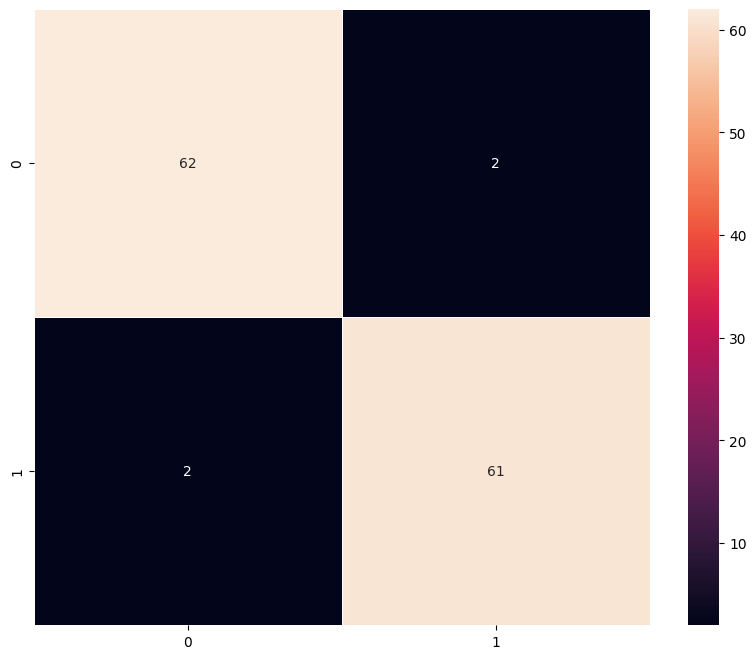

In [82]:
# Plot confusion matrix for test set predictions
plot_confusion_matrix(cnn_model, x_test_normalized_rgb, y_test_rgb, ml=True)

In [85]:

performance_val_basic_cnn = model_performance_classification(cnn_model, x_val_normalized_rgb, y_val_rgb)
print("Performance of Basic CNN Model on Test set of RGB Images:")
print(performance_val_basic_cnn)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Performance of Basic CNN Model on Test set of RGB Images:
   Accuracy   Recall  Precision  F1 Score
0   0.97619  0.97619   0.977257  0.976168
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Performance of Basic CNN Model on Test set of RGB Images:
   Accuracy   Recall  Precision  F1 Score
0   0.97619  0.97619   0.977257  0.976168


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


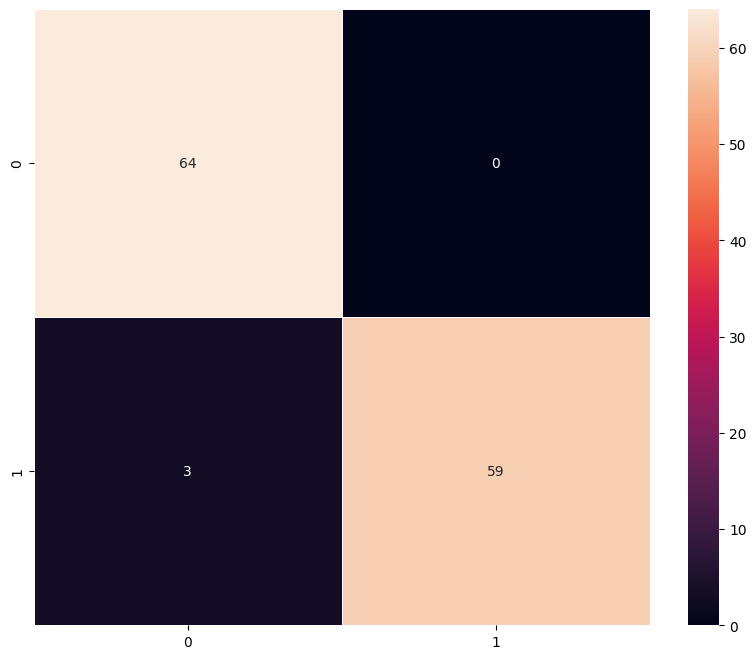

In [86]:
# Plot confusion matrix for test set predictions
plot_confusion_matrix(cnn_model, x_val_normalized_rgb, y_val_rgb, ml=True)

### Vizualizing the predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


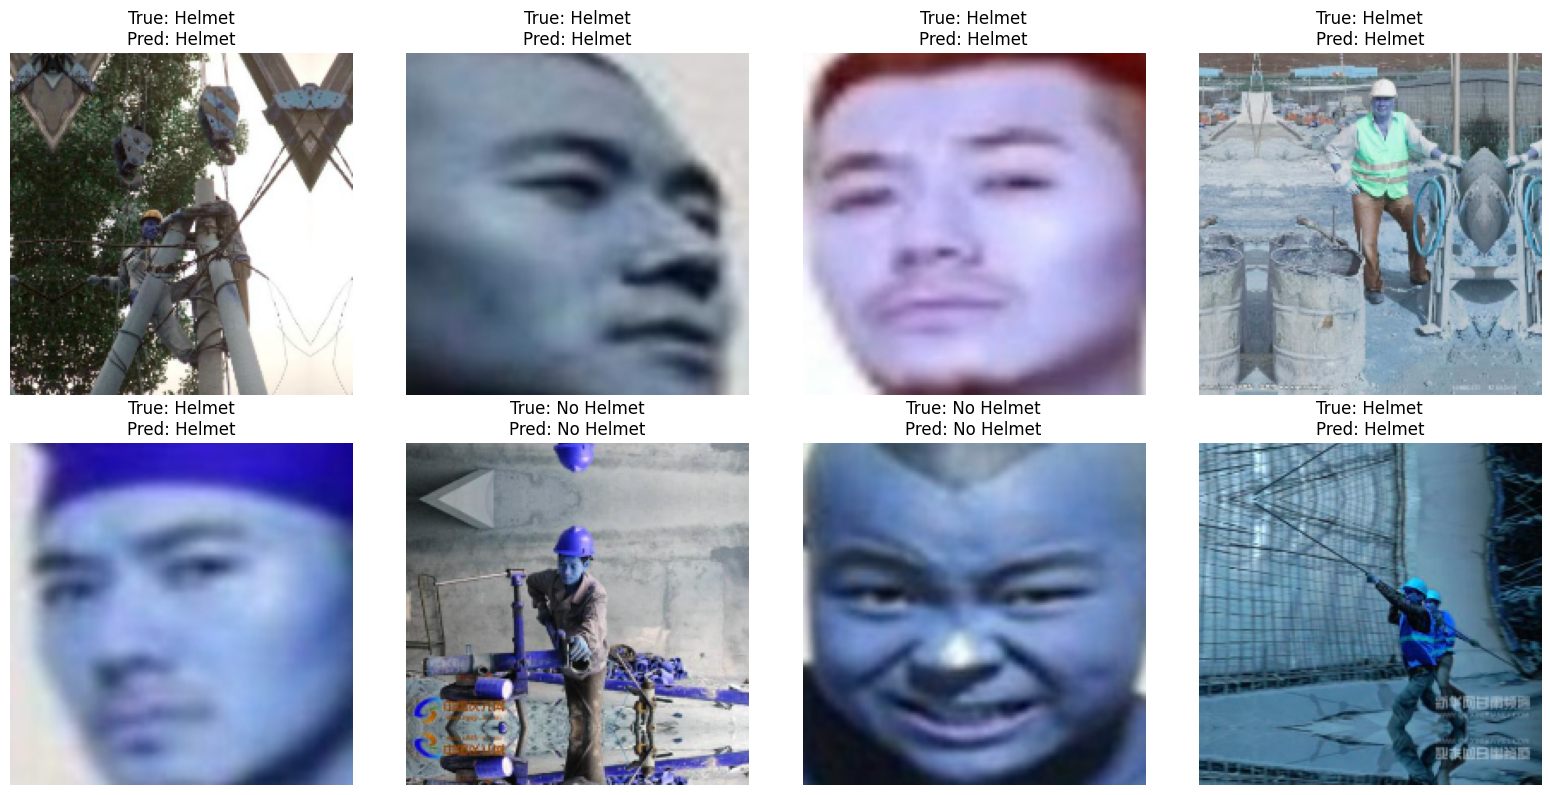

In [88]:
# Visualize predictions on val images
num_samples = 8
plt.figure(figsize=(16, 8))
pred_probs = cnn_model.predict(x_val_normalized_rgb[:num_samples])
pred_labels = (pred_probs > 0.5).astype(int).reshape(-1)
for i in range(num_samples):
    plt.subplot(2, num_samples//2, i+1)
    plt.imshow(x_test_rgb[i])
    true_label = y_val_rgb.iloc[i] if hasattr(y_val_rgb, 'iloc') else y_val_rgb[i]
    plt.title(f"True: {'Helmet' if true_label==1 else 'No Helmet'}\nPred: {'Helmet' if pred_labels[i]==1 else 'No Helmet'}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Model 2: (VGG-16 (Base))

In [89]:
# VGG16-based model for helmet detection (using RGB images)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load VGG16 base (without top, with imagenet weights)
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=x_train_rgb.shape[1:])
vgg_base.trainable = False  # Freeze base layers

# Add custom classification head
x = vgg_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

vgg16_model = Model(inputs=vgg_base.input, outputs=output)

vgg16_model.compile(optimizer=Adam(learning_rate=0.001),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

vgg16_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 200, 200, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 100, 100, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,747,585 (56.26 MB)

 Trainable params: 32,897 (128.50 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Visualizing the prediction:

## Model 3: (VGG-16 (Base + FFNN))

#### Visualizing the predictions

## Model 4: (VGG-16 (Base + FFNN + Data Augmentation)

- In most of the real-world case studies, it is challenging to acquire a large number of images and then train CNNs.
- To overcome this problem, one approach we might consider is **Data Augmentation**.
- CNNs have the property of **translational invariance**, which means they can recognise an object even if its appearance shifts translationally in some way. - Taking this attribute into account, we can augment the images using the techniques listed below

    -  Horizontal Flip (should be set to True/False)
    -  Vertical Flip (should be set to True/False)
    -  Height Shift (should be between 0 and 1)
    -  Width Shift (should be between 0 and 1)
    -  Rotation (should be between 0 and 180)
    -  Shear (should be between 0 and 1)
    -  Zoom (should be between 0 and 1) etc.

Remember, **data augmentation should not be used in the validation/test data set**.

#### Visualizing the predictions

# **Model Performance Comparison and Final Model Selection**

## Test Performance

# **Actionable Insights & Recommendations**

-
-

<font size=5 color='blue'>Power Ahead!</font>
___